# Gordon et al. 2023 Section 4.2
# Updated 5/23/23

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os 

# Choosing which SN to use as backgrounds from the big list required a lot of manual inspection - here's the base code for that one one of the ones we did use. 

(You will need to update my savedir things)

The function will give an approximate value for the mean magnitude prior to the orbit gap - this is a good way to quickly guesstimate whether or not the target will work as a background producer. 

In [2]:
import tessreduce as tr
def mag_plot_download(i, df, cdir = "/Users/lindseygordon/.lightkurve-cache/tesscut/",
                     data_dir = "/Users/lindseygordon/etsfit_local/tessreduce_lc/"):
    """ 
    Retrieve the magnitude data for the ith SN in the given dataframe. 
    i = index 
    df = pandas dataframe of all SN to lookup from. 
    """
    sec = int(df["Sector"].iloc[i]) #sector to look in
    print(df['Name'].iloc[i][3:]) #name of target being looked up 
    targ = df['Name'].iloc[i][3:]
    
    try: # vizier...likes to timeout. 
        obs = tr.sn_lookup(targ) #look it up
        lookup = obs[np.where(np.asarray(obs)[:,2] == sec)[0][0]] #obs in correct sector
        tess = tr.tessreduce(obs_list=lookup,plot=False,reduce=True) #get tessredue data
    except ValueError:   
        print("value error - something is wrong with vizier or no target in pixels")
    except IndexError:
        print("index error - tesscut thinks it wasn't observed")
    except ConnectionResetError:
        print("vizier problems")
    except TimeoutError:
        print("2 vizier 2 problems")
    except ConnectionError:
        print("vizier problems: tokyo drift")
    
    #holder = ""
    for root, dirs, files in os.walk(cdir):
        for name in files:
            holder = root + "/" + name
            print(holder)
            try:
                filenamepieces = name.split("-")
                sector = str( filenamepieces[1][3:])
                camera = str( filenamepieces[2])
                ccd = str(filenamepieces[3][0])
                os.remove(holder)
                break
            except IndexError:
                print("eek")
                os.remove(holder)
                continue
    
    targlabel = targ + sector + camera + ccd 
    newfolder = data_dir + targlabel + "/"
    if not os.path.exists(newfolder):
        os.mkdir(newfolder)
        filesave = newfolder + targlabel + "-tessreduce.csv"
        tess.save_lc(filesave) #save flux
        tess.to_flux()
        filesave = newfolder + targlabel + "-tessreduce-fluxconverted.csv"
        tess.save_lc(filesave)

    #make subfolder to save into 
    targlabel = targ + sector + camera + ccd 
    l_mag = tess.to_mag() #get magnitudes
    time = l_mag[0] 
    mag = l_mag[1]
    m = int(len(time)/2 ) - 40 # this is a good way to roughly estimate the pre-orbit gap position
    
    fig, ax = plt.subplots(1,1, figsize=(8,3))
    from astropy.time import Time
    time = Time(time, format='mjd').jd
    ddate = Time(df["Discovery Date (UT)"].iloc[i]).jd
    #print(ddate)
    
    ax.scatter(time, mag)
    ax.invert_yaxis()
    ax.axvline(ddate, color='green')
    ax.axvline(time[m], color='red')
    ax.set_title(targlabel)
    
    print(targlabel, "Mean Mag:", np.ma.masked_invalid(mag[0:m]).mean()) #approx pre-orbit gap mean
    return tess, ddate

In [ ]:
TNS_file = "/Users/lindseygordon/etsfit_local/august2022crossmatch/all-tesscut-matches.csv"
df = pd.read_csv(TNS_file)
data_dir = "/Users/lindseygordon/etsfit_local/tessreduce_lc/"

candidate_backgrounds = ["2018fhw"]
ind = 0
df2 = df[df["Name"].str.contains(candidate_backgrounds[ind])]
print(df2)
tess_, dd_ = mag_plot_download(ind, df2)

Once SN to use are chosen, download tessreduce flux data - helper fxns in the utilities file. 

In [ ]:
import etsfit.utils.utilities as ut
cdir = "/Users/lindseygordon/.lightkurve-cache/tesscut/"

#just get the TNS sublist of backgrounds
ut.get_sublist(TNS_file, candidate_backgrounds, TNS_limited)
TNS_limited = "/Users/lindseygordon/etsfit_local/completeness-injections/tns_limited.csv"

#download them 
ut.tr_downloader(TNS_limited, data_dir, cdir)

|   Sector | Covers   |   Time difference  |
|          |          |             (days) |
|----------+----------+--------------------|
|       21 | True     |                  0 |
|       48 | False    |                733 |
getting TPF from TESScut
made reference
made source mask
calculating background
background subtracted
calculating centroids
!!Re-running for difference image!!
shifting images
remade mask
background
Background correlation correction
Field calibration
Target is above -30 dec, calibrating to PS1 photometry.


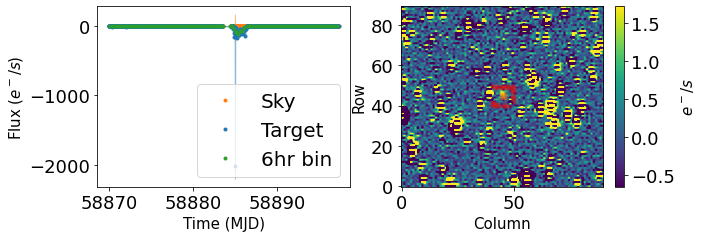

2020azn: flux range: 14.14496207585217
20.476042856706723


In [25]:
# get flux ranges for the three bad Ias used
IJ.get_flux_range(2)

# Injections:

In [ ]:
# Real Bad Ia's: (4.2.2)
import etsfit.utils.injects as IJ
save_dir = "/Users/lindseygordon/research/paper_outputs/CR_real_TESS_bg/"
n_total = 10 #how many total
p_inj = 0.6
bg = 2 #2020azn 
bg_type = "badIa"
ctf = IJ.artificial_injections(save_dir, n_total, p_inj)    
ctf.run_all(bg_type, bg)

In [ ]:
# Fake Ia BG: (4.2.1)
save_dir = "/Users/lindseygordon/research/paper_outputs/CR_fake_TESS_bg/"
n_total = 10 #how many total
p_inj = 0.6
bg = 0 #2020tld
bg_type = "noise"
ctf = IJ.artificial_injections(save_dir, n_total, p_inj)    
ctf.run_all(bg_type, bg)